# Featured Recipe #2: Simulating a Physical System by Minimizing an Energy

> This is a featured recipe from the [**IPython Cookbook**](http://ipython-books.github.io/), the definitive guide to **high-performance scientific computing** and **data science** in Python.

Mathematical optimization is a wide area of applied mathematics. It consists in finding a best solution to a given problem. Many real-world problems can be expressed in an optimization framework.

In this recipe, we show how to find the equilibrium configuration of a physical system by minimizing its potential energy. More specifically, we consider a structure made of masses and springs, attached to a vertical wall and subject to gravity. Starting from an initial position, we want to find the equilibrium configuration where the gravity and elastic forces compensate.

## How to do it...

1. Let's import NumPy, SciPy and matplotlib.

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = matplotlib.rcParams['figure.dpi'] = 144

2. We define a few constants in the International System of Units.

In [2]:
g = 9.81  # gravity of Earth
m = .1  # mass, in kg
n = 20  # number of masses
e = .1  # initial distance between the masses
l = e  # relaxed length of the springs
k = 10000  # spring stiffness

3. We define the initial positions of the masses. They are arranged on a two-dimensional grid with two lines and $n/2$ columns.

In [3]:
P0 = np.zeros((n, 2))
P0[:,0] = np.repeat(e*np.arange(n//2), 2)
P0[:,1] = np.tile((0,-e), n//2)

4. Now, let's define the connectivity matrix between the masses. Coefficient $i,j$ is $1$ if masses $i$ and $j$ are connected by a spring.

In [4]:
A = np.eye(n, n, 1) + np.eye(n, n, 2)

5. We also specify the spring stiffness of each spring. It is $l$, except for *diagonal* springs where it is $l \times \sqrt{2}$.

In [5]:
L = l * (np.eye(n, n, 1) + np.eye(n, n, 2))
for i in range(n//2-1):
    L[2*i+1,2*i+2] *= np.sqrt(2)

6. We also need the indices of the spring connections.

In [6]:
I, J = np.nonzero(A)

7. The `dist` function computes the distance matrix (distance between any pair of masses).

In [7]:
dist = lambda P: np.sqrt((P[:,0]-P[:,0][:, np.newaxis])**2 + 
                         (P[:,1]-P[:,1][:, np.newaxis])**2)

8. We define a function that displays the system. The springs are colored according to their tension.

In [8]:
def spring_color_map(c):
    min_c, max_c = -0.00635369422326, 0.00836362559722
    ratio = (max_c-c) / (max_c-min_c)
    color = plt.cm.coolwarm(ratio)
    shading = np.sqrt(abs(ratio-0.5)*2)
    return (shading*color[0], shading*color[1], shading*color[2], color[3])

def show_bar(P):
    plt.figure(figsize=(5,4));
    # Wall.
    plt.axvline(0, color='k', lw=3);
    # Distance matrix.
    D = dist(P)
    # We plot the springs.
    for i, j in zip(I, J):
        # The color depends on the spring tension, which
        # is proportional to the spring elongation.
        c = D[i,j] - L[i,j]
        plt.plot(P[[i,j],0], P[[i,j],1], 
                 lw=2, color=spring_color_map(c));
    # We plot the masses.
    plt.plot(P[[I,J],0], P[[I,J],1], 'ok',);
    # We configure the axes.
    plt.axis('equal');
    plt.xlim(P[:,0].min()-e/2, P[:,0].max()+e/2);
    plt.ylim(P[:,1].min()-e/2, P[:,1].max()+e/2);
    plt.xticks([]); plt.yticks([]);

9. Here is the system in its initial configuration.

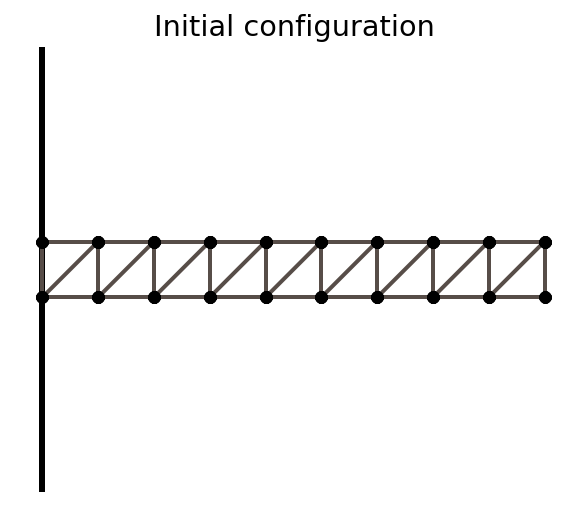

In [9]:
show_bar(P0);
plt.title("Initial configuration");

10. To find the equilibrium state, we need to minimize the total potential energy of the system. The following function computes the energy of the system, given the positions of the masses. This function is explained in *How it works...*.

In [10]:
def energy(P):
    # The argument P is a vector (flattened matrix).
    # We convert it to a matrix here.
    P = P.reshape((-1, 2))
    # We compute the distance matrix.
    D = dist(P)
    # The potential energy is the sum of the
    # gravitational and elastic potential energies.
    return (g * m * P[:,1].sum() + 
            .5 * (k * A * (D - L)**2).sum())

11. Let's compute the potential energy of the initial configuration.

In [11]:
energy(P0.ravel())

-0.98100000000000009

12. Now, let's minimize the potential energy with a function minimization method. We need a **constrained optimization algorithm**, because we make the assumption that the two first masses are fixed to the wall. Therefore, their positions cannot change. The [**L-BFGS-B**](http://en.wikipedia.org/wiki/Limited-memory_BFGS#L-BFGS-B) algorithm, a variant of the BFGS algorithm, accepts bound constraints. Here, we force the first two points to stay at their initial positions, whereas there are no constraints on the other points. The `minimize` function accepts a `bounds` list containing, for each dimension, a pair of `[min, max]` values.

In [12]:
bounds = np.c_[P0[:2,:].ravel(), P0[:2,:].ravel()].tolist() + \
         [[None, None]] * (2*(n-2))

In [13]:
P1 = opt.minimize(energy, P0.ravel(),
                  method='L-BFGS-B',
                  bounds=bounds).x.reshape((-1, 2))

13. Let's display the stable configuration.

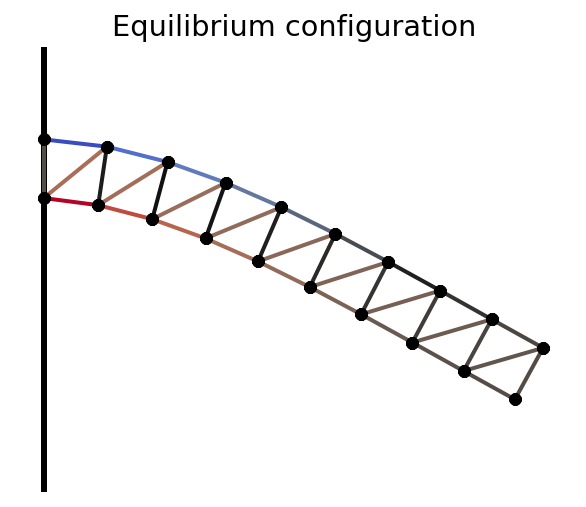

In [14]:
show_bar(P1);
plt.title("Equilibrium configuration");

This configuration looks realistic. The tension appears to be maximal on the top springs near the wall.

## How it works...

This example is conceptually simple. The state of the system is only described by the positions of the masses. If we can write a Python function that returns the total energy of the system, finding the equilibrium is just a matter of minimizing this function. This is the **principle of minimum total potential energy**, due to the second law of thermodynamics.

Here, we give an expression of the total energy of the system. Since we are only interested in the *equilibrium*, we omit any kinetic aspect and we only consider potential energy due to gravity (**gravitational force**) and spring forces (**elastic potential energy**).

Let $U$ be the total potential energy of the system. It is the sum of the gravitational potential energies of the masses, and the elastic potential energies of the springs. Therefore:

$$U = \sum_{i=1}^n mgy_i + \frac{1}{2} \sum_{i,j=1}^n k a_{ij} \left( ||\mathbf{p}_i - \mathbf{p}_j|| - l_{ij} \right)^2$$

where:

* $m$ is the mass,
* $g$ is the gravity of Earth,
* $k$ is the stiffness of the springs,
* $\mathbf{p}_i = (x_i, y_i)$ is the position of mass $i$,
* $a_{ij}$ is 1 if masses $i$ and $j$ are attached by a spring, $0$ otherwise,
* $l_{ij}$ is the relaxed length of spring $(i,j)$, or $0$ if masses $i$ and $j$ are not attached.

The `energy` function implements this formula using vectorized computations on NumPy arrays.

## There's more...

The following references contain details about the physics behind this formula:

* [Potential energy](http://en.wikipedia.org/wiki/Potential_energy).
* [Elastic potential energy](http://en.wikipedia.org/wiki/Elastic_potential_energy).
* [Hooke's law, which is the linear approximation of the spring's response](http://en.wikipedia.org/wiki/Hooke%27s_law).
* [Principle of minimum energy](http://en.wikipedia.org/wiki/Minimum_total_potential_energy_principle).

You will find related recipes on the [book's repository](https://github.com/ipython-books/cookbook-code).

> This was a featured recipe from the [IPython Cookbook](http://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net), Packt Publishing, 2014.